In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from rnn import ImageCaptioning
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
data = load_coco_data(max_train=50, pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
    if type(v) == np.ndarray:
        print k, type(v), v.shape, v.dtype
    else:
        print k, type(v), len(v)

idx_to_word <type 'list'> 1004
train_captions <type 'numpy.ndarray'> (50, 17) int32
val_captions <type 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <type 'numpy.ndarray'> (50,) int32
val_features <type 'numpy.ndarray'> (40504, 512) float32
val_image_idxs <type 'numpy.ndarray'> (195954,) int32
train_features <type 'numpy.ndarray'> (82783, 512) float32
train_urls <type 'numpy.ndarray'> (82783,) |S63
val_urls <type 'numpy.ndarray'> (40504,) |S63
word_to_idx <type 'dict'> 1004


In [3]:
word_to_idx = data['word_to_idx']
idx_to_word = {i: w for w, i in word_to_idx.iteritems()}
small_data = sample_coco_minibatch(data, split='train', batch_size=100)  # get 100 train data
train_captions, train_features, urls = small_data
start_word = idx_to_word[train_captions[0,0]]
print "start word: ", start_word

start word:  <START>


In [4]:
image_captioning = ImageCaptioning(word_to_idx, batch_size= 100, dim_feature=512, dim_embed=128,
                                   dim_hidden=128, n_time_step=16, cell_type='lstm', dtype=tf.float32)

logits, loss = image_captioning.build_model()
optimizer = tf.train.AdamOptimizer(0.03).minimize(loss)

loss at epoch 0: 7877.717285
generated sentence: <START> front small <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END> <END>
loss at epoch 20: 1051.921631
generated sentence: <START> a surfer is in the middle of a ocean wave <END> <END> <END> <END> <END> <END>
loss at epoch 40: 61.188148
generated sentence: <START> a surfer is in the middle of an ocean wave <END> <END> <END> <END> <END> <END>
loss at epoch 60: 12.884109
generated sentence: <START> a surfer is in the middle of an ocean wave <END> <END> <END> <END> <END> <END>
loss at epoch 80: 6.721651
generated sentence: <START> a surfer is in the middle of an ocean wave <END> <END> <END> <END> <END> <END>
loss at epoch 100: 4.749577
generated sentence: <START> a surfer is in the middle of an ocean wave <END> <END> <END> <END> <END> <END>
loss at epoch 120: 3.725468
generated sentence: <START> a surfer is in the middle of an ocean wave <END> <END> <END> <END> <END> <END>
loss at epoch 140: 3.056239
generated

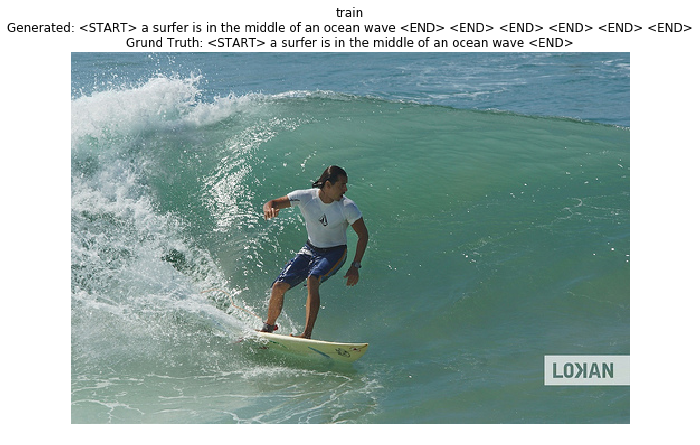

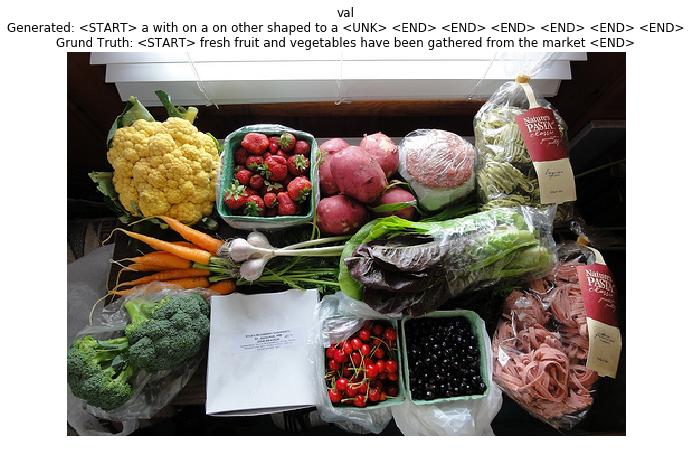

In [8]:
n_epochs = 200
with tf.Session() as sess:
    tf.initialize_all_variables().run()

    for e in range(n_epochs):
        _, l = sess.run([optimizer, loss], {image_captioning.features: train_features, image_captioning.captions: train_captions})
        #print "loss at epoch %d: %f" %(e, l)  
        if e % 20 == 0:
            print "loss at epoch %d: %f" %(e, l)  
            score = sess.run(logits, {image_captioning.features: train_features, image_captioning.captions: train_captions})  # (N, T, V)
            idxs = np.argmax(score, 2)  # (N, T)
            idx = idxs[0]  # (T)
            sentence = [idx_to_word[i] for i in idx]
            print "generated sentence: %s" %(start_word+ " " + ' '.join(sentence))
    
    for split in ['train', 'val']:
        if split == 'val':
            small_data = sample_coco_minibatch(data, split=split, batch_size=100)
            train_captions, train_features, urls = small_data # not train, it's validation data but do not edit
        
        score = sess.run(logits, {image_captioning.features: train_features, image_captioning.captions: train_captions})
        idxs = np.argmax(score, 2)  # (N, T)
        #idx = idxs[0]  # (T)
        sampled_captions = []
        for i in range(idxs.shape[0]):
            sentence = []
            for j in range(idxs.shape[1]):
                sentence.append(idx_to_word[idxs[i,j]])
            sentence = start_word+ " " +' '.join(sentence)
            sampled_captions.append(sentence)
        gt_captions = decode_captions(train_captions, data['idx_to_word'])
        i = 0
        for gt_caption, sample_caption, url in zip(gt_captions, sampled_captions, urls):
            if i == 1:
                break
            i += 1
            plt.imshow(image_from_url(url))
            plt.title('%s\nGenerated: %s\nGrund Truth: %s' % (split, sample_caption, gt_caption))
            plt.axis('off')
            plt.show()